In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [4]:
sc.set_figure_params(dpi=100, facecolor=None, color_map="seismic", frameon=False, vector_friendly=True, transparent=True)
sc.settings._vector_friendly = False

In [5]:
# set working directory
project_dir = "/Users/cenkcelik/Cenk_scoring/"
working_dir = project_dir + ""
os.chdir(working_dir)

# set figure directory
figure_dir = working_dir + "figures/"

# processed data directory
processed_data = working_dir + "processed_data/"

In [6]:
# import a local package
import sys
sys.path.append("/Users/cenkcelik/Documents/GitHub/EnrichMap/")
import enrichmap as em

In [7]:
adata = sq.datasets.visium_hne_adata()

In [8]:
adata.layers["counts"] = adata.raw.X.copy()

In [9]:
adata.X = adata.layers["counts"].copy()

In [10]:
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["log1p_norm"] = adata.X.copy()

In [11]:
sc.tl.rank_genes_groups(adata, groupby="cluster", method="wilcoxon", layer="log1p_norm", use_raw=False)
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.5, min_fold_change=2, max_out_group_fraction=0.5)

In [12]:
gene_set_10 = adata.uns["rank_genes_groups"]["names"]["Pyramidal_layer"][:10].tolist()

### EnrichMap

In [29]:
# loop over different neighbors
for n_neighbors in range(6, 61, 6):
    # calculate the score
    em.tl.score(
        adata,
        gene_set=gene_set_10,
        score_key=f"{n_neighbors}_neighbors",
        n_neighbors=n_neighbors
    )

Scoring signatures:   0%|          | 0/1 [00:00<?, ?it/s]

Scoring signatures: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


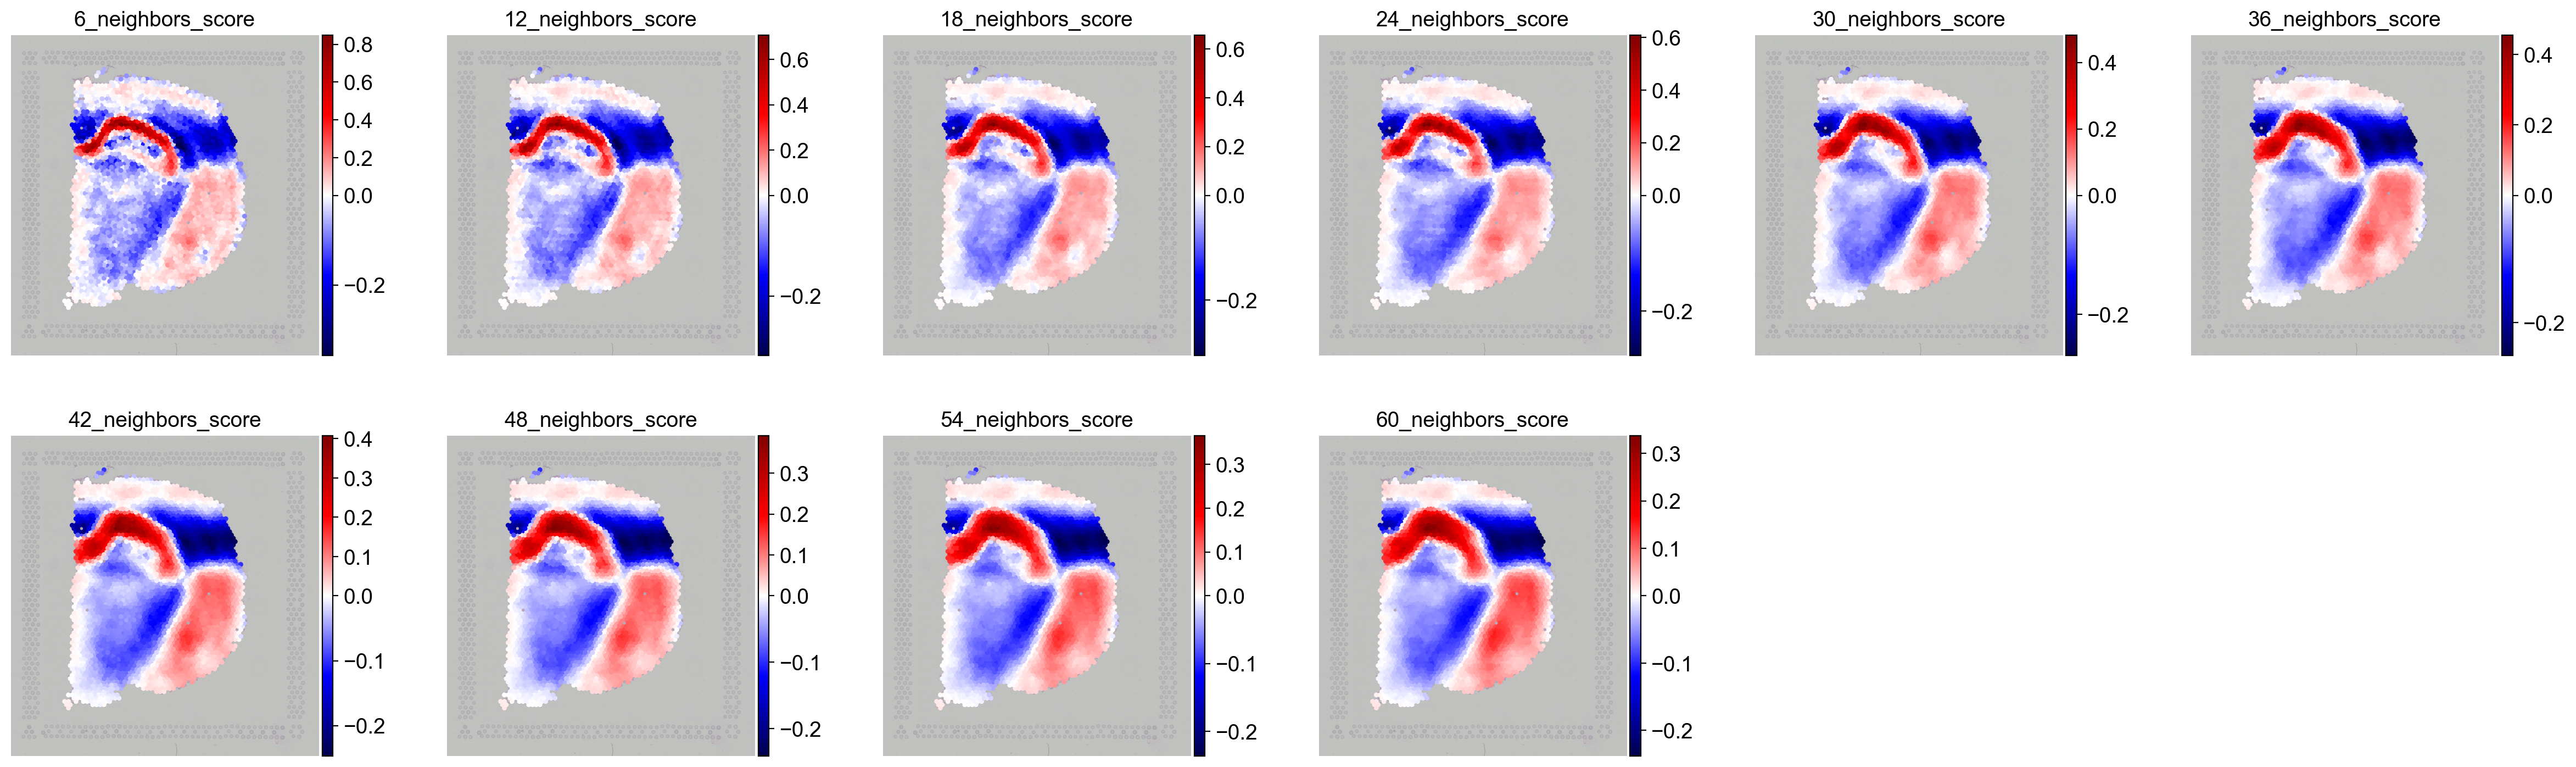

In [30]:
score_keys = [f"{n_neighbors}_neighbors_score" for n_neighbors in range(6, 61, 6)]

# plot the scores
em.pl.spatial_enrichmap(
    adata,
    score_key=score_keys,
    ncols=6,
    save="spatial_enrichmap_neighbours.pdf"
)

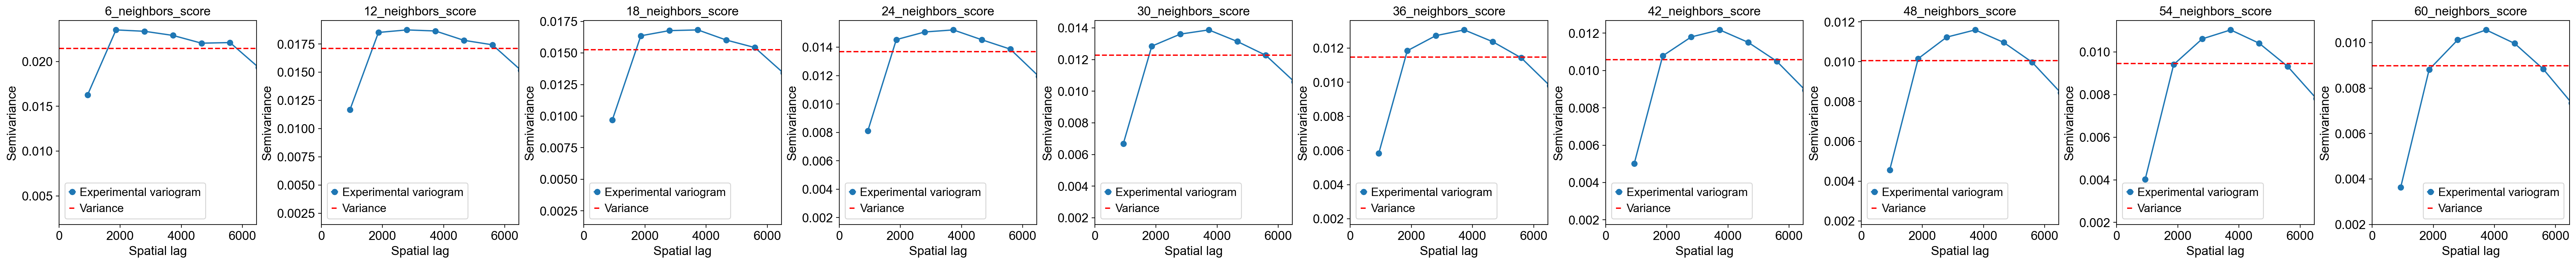

In [31]:
em.pl.variogram(
    adata,
    score_keys=score_keys,
    save="variogram_neighbours.pdf",
)

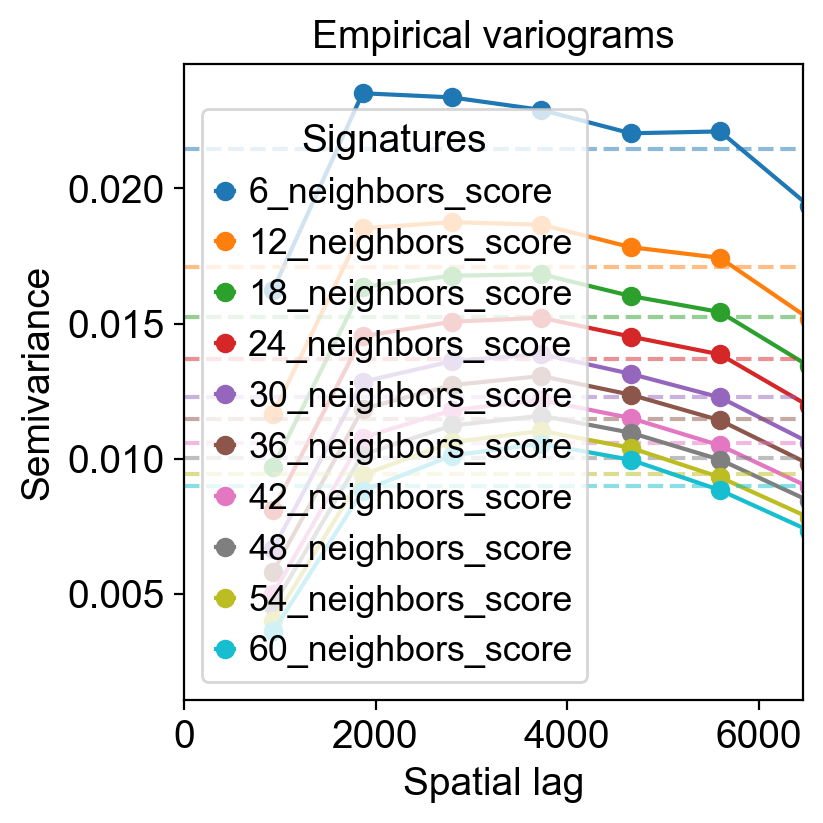

In [32]:
em.pl.variogram_all(
    adata,
    score_keys=score_keys,
    save="variogram_neighbours_all.pdf",
)

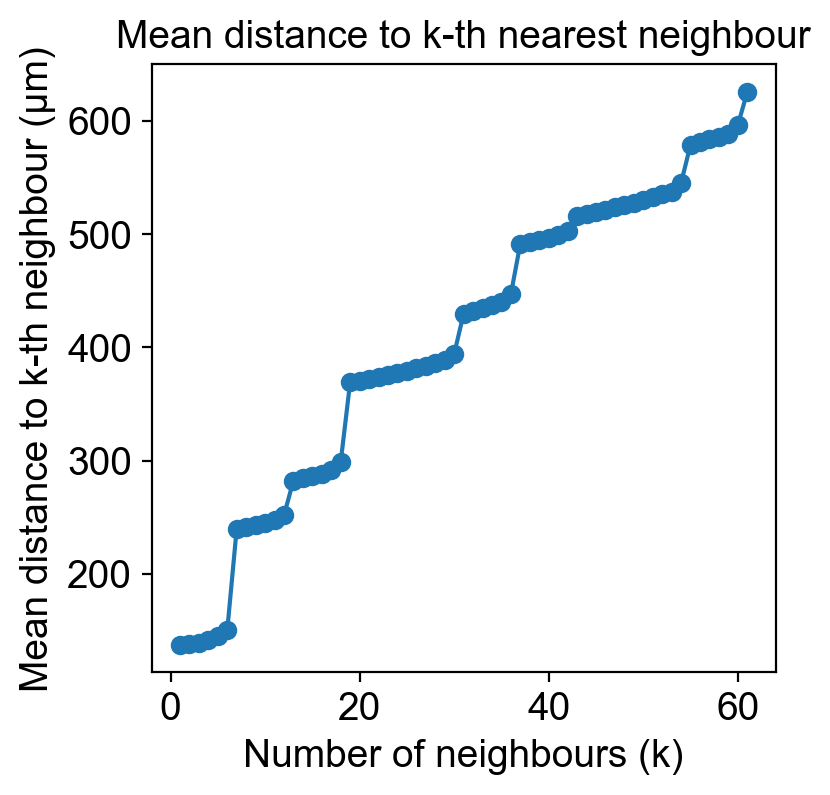

In [33]:
from sklearn.neighbors import NearestNeighbors

# Coordinates of spots (2D array: n_spots x 2)
coords = adata.obsm['spatial']  # e.g. Visium spatial coords

max_k = 61  # max neighbours to test
nbrs = NearestNeighbors(n_neighbors=max_k + 1).fit(coords)
distances, indices = nbrs.kneighbors(coords)

# distances includes distance to self at index 0, so skip it
distances = distances[:, 1:]  # shape: (n_spots, max_k)

# Calculate mean distance to k-th neighbour over all spots
mean_distances = distances.mean(axis=0)  # length max_k

plt.plot(range(1, max_k + 1), mean_distances, marker='o')
plt.xlabel('Number of neighbours (k)')
plt.ylabel('Mean distance to k-th neighbour (µm)')
plt.title('Mean distance to k-th nearest neighbour')
plt.grid(False)
plt.savefig(figure_dir + "mean_distance_to_kth_neighbour.pdf", bbox_inches='tight', dpi=300)
plt.show()